## Predicción del precio de los inmuebles en Saratoga, NY
--------


In [55]:
import time
import pandas as pd
import numpy as np
from sklearn import datasets, linear_model
import statsmodels.formula.api as smf # para crear un modelo lineal

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
url = r"C:\Users\mhern\Desktop\Marcos\Udemy - Formaciones\Curso Datascience\Mis_datasets_de_ejemplo/SaratogaHouses.csv"
datos = pd.read_csv(url, sep=",")

# Se renombran las columnas para que sean más descriptivas
datos.columns = ["precio", "metros_totales", "antiguedad", "precio_terreno",
                 "metros_habitables", "universitarios", "dormitorios", 
                 "chimenea", "banyos", "habitaciones", "calefaccion",
                 "consumo_calefacion", "desague", "vistas_lago",
                 "nueva_construccion", "aire_acondicionado"]
datos.head(4)

,precio,metros_totales,antiguedad,precio_terreno,metros_habitables,universitarios,dormitorios,chimenea,banyos,habitaciones,calefaccion,consumo_calefacion,desague,vistas_lago,nueva_construccion,aire_acondicionado
0,132500,0.09,42,50000,906,35,2,1,1.0,5,electric,electric,septic,No,No,No
1,181115,0.92,0,22300,1953,51,3,0,2.5,6,hot water/steam,gas,septic,No,No,No
2,109000,0.19,133,7300,1944,51,4,1,1.0,8,hot water/steam,gas,public/commercial,No,No,No
3,155000,0.41,13,18700,1944,51,3,1,1.5,5,hot air,gas,septic,No,No,No


## División del dataset en Training y Testing

(array([  8.,  31., 126., 278., 476., 423., 254., 100.,  29.,   3.]),
 array([-3.47664883, -2.7664779 , -2.05630697, -1.34613605, -0.63596512,
         0.07420581,  0.78437674,  1.49454766,  2.20471859,  2.91488952,
         3.62506044]),
 <BarContainer object of 10 artists>)

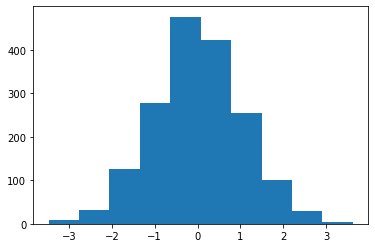

In [3]:
# construyo dist normal del tamaño del dataset
a = np.random.randn(len(datos))
plt.hist(a)

In [4]:
check = (a<0.8)
datos_training = datos[check]
datos_testing = datos[~check]

len(datos_training), len(datos_testing)

(1350, 378)

## Análisis exploratorio de los datos

### Tipo de cada columna

In [5]:
# En pandas, el tipo "object" hace referencia a strings
# datos.dtypes
datos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1728 entries, 0 to 1727
Data columns (total 16 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   precio              1728 non-null   int64  
 1   metros_totales      1728 non-null   float64
 2   antiguedad          1728 non-null   int64  
 3   precio_terreno      1728 non-null   int64  
 4   metros_habitables   1728 non-null   int64  
 5   universitarios      1728 non-null   int64  
 6   dormitorios         1728 non-null   int64  
 7   chimenea            1728 non-null   int64  
 8   banyos              1728 non-null   float64
 9   habitaciones        1728 non-null   int64  
 10  calefaccion         1728 non-null   object 
 11  consumo_calefacion  1728 non-null   object 
 12  desague             1728 non-null   object 
 13  vistas_lago         1728 non-null   object 
 14  nueva_construccion  1728 non-null   object 
 15  aire_acondicionado  1728 non-null   object 
dtypes: flo

Los valores ausentes son muy importantes a la hora de crear modelos, la mayoría de algoritmos no aceptan observaciones incompletas o bien se ven muy influenciados por ellas.

**NOTA:** Es importante no tener nulos en los datos. Habria que rellenar en ese caso.

### Variable respuesta
Es muy importante estudiar la distribución de la variable respuesta, ya que, a fin de cuentas, es lo que interesa predecir.<br></br>
La variable precio tiene una distribución asimétrica con una cola positiva debido a que, unas pocas viviendas, tienen un precio muy superior a la media. Este tipo de distribución suele visualizarse mejor tras aplicar el logarítmica o la raíz cuadrada.

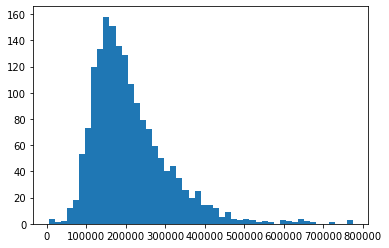

In [6]:
dummy=plt.hist(datos.precio, bins=50)

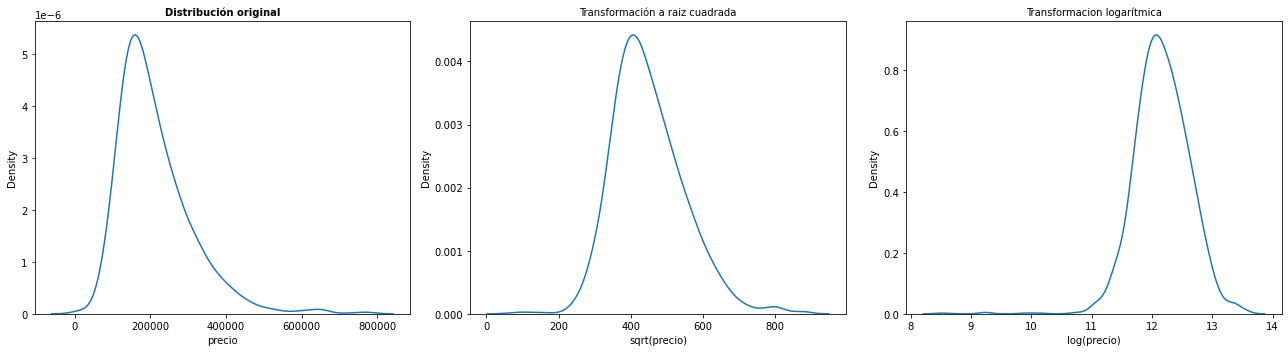

In [7]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 5))

sns.kdeplot(data=datos, x="precio", ax=axes[0] )
axes[0].set_title("Distribución original", fontsize = 'medium', fontweight = "bold")
axes[0].set_xlabel('precio', fontsize='medium') 
axes[0].tick_params(labelsize = 10)

sns.kdeplot(data=datos, x=np.sqrt(datos.precio), ax=axes[1] )
axes[1].set_title("Transformación a raiz cuadrada", fontsize = 'medium')
axes[1].set_xlabel('sqrt(precio)', fontsize='medium') 
axes[1].tick_params(labelsize = 10)

sns.kdeplot(data=np.log(datos.precio), ax=axes[2] )
axes[2].set_title("Transformacion logarítmica", fontsize = 'medium')
axes[2].set_xlabel('log(precio)', fontsize='medium') 
axes[2].tick_params(labelsize = 10)

fig.tight_layout()

Algunos modelos de machine learning y aprendizaje estadístico requieren que la variable respuesta se distribuya de una forma determinada. Por ejemplo, para los modelos de regresión lineal (LM), la distribución tiene que ser de tipo normal. Para los modelos lineales generalizados (GLM), la distribución tiene que ser de la familia exponencial.

Existen varias librerías en python que permiten identificar a qué distribución se ajustan mejor los datos, una de ellas es <code>fitter</code>. Esta librería permite ajustar cualquiera de las 80 distribuciones implementadas en scipy.

In [8]:
from fitter import Fitter

distros = ['cauchy', 'chi2', 'expon',  'exponpow', 'gamma',
                  'norm', 'powerlaw', 'beta', 'logistic']

ft = Fitter(datos.precio, distributions=distros)
ft.fit()
ft.summary(Nbest=5, plot=False)

,sumsquare_error,aic,bic,kl_div
beta,2.497420e-11,3068.852573,-55037.908642,inf
logistic,4.913880e-11,3147.967042,-53883.297844,inf
cauchy,5.221450e-11,2956.669693,-53778.388707,inf
chi2,5.776892e-11,3321.818880,-53596.249282,inf
norm,6.947514e-11,3324.534158,-53284.856663,inf


In [9]:
ft.get_best(method = 'sumsquare_error')

{'beta': {'a': 5.269813405374375,
  'b': 3032086461568.871,
  'loc': -3078.7497036941077,
  'scale': 1.2411771591985462e+17}}

### Variables numéricas

In [10]:
# columnas con variables numéricas
datos.select_dtypes(include=['float64','int','int64']).describe()

,precio,metros_totales,antiguedad,precio_terreno,metros_habitables,universitarios,dormitorios,chimenea,banyos,habitaciones
count,1728.000000,1728.000000,1728.000000,1728.000000,1728.000000,1728.000000,1728.000000,1728.000000,1728.000000,1728.000000
mean,211966.705440,0.500214,27.916088,34557.187500,1754.975694,55.567708,3.154514,0.601852,1.900174,7.041667
std,98441.391015,0.698680,29.209988,35021.168056,619.935553,10.333581,0.817351,0.556102,0.658352,2.316453
min,5000.000000,0.000000,0.000000,200.000000,616.000000,20.000000,1.000000,0.000000,0.000000,2.000000
25%,145000.000000,0.170000,13.000000,15100.000000,1300.000000,52.000000,3.000000,0.000000,1.500000,5.000000
50%,189900.000000,0.370000,19.000000,25000.000000,1634.500000,57.000000,3.000000,1.000000,2.000000,7.000000
75%,259000.000000,0.540000,34.000000,40200.000000,2137.750000,64.000000,4.000000,1.000000,2.500000,8.250000
max,775000.000000,12.200000,225.000000,412600.000000,5228.000000,82.000000,7.000000,4.000000,4.500000,12.000000


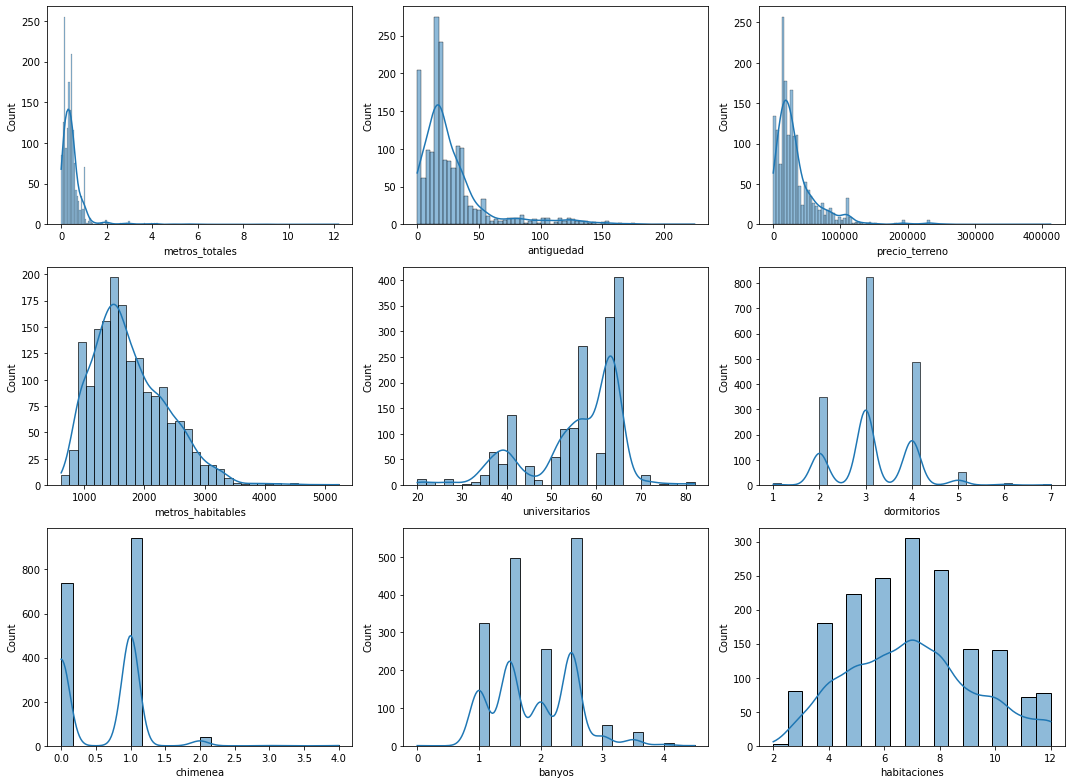

In [11]:
# Grafico de distribución para cada variable numérica
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15,11))

#ax is a two-dimensional array: one dimension for the rows, one for the columns.
#if you want to iterate through the subplots in the way you do it now, by flattening ax first: ax = ax.flatten()
#and now ax is a one dimensional array. 
axes = axes.flat

columnas_numeric = datos.select_dtypes(include=['float64', 'int64', 'int']).columns
columnas_numeric = columnas_numeric.drop('precio')

for i, colum  in enumerate(columnas_numeric):
    sns.histplot(data=datos, x=colum , stat='count', kde=True, ax= axes[i] )
    #axes[i].set_title(col, fontsize = 'medium', fontweight = "bold")
    axes[i].tick_params(labelsize = 10)

fig.tight_layout()


In [12]:
# Valores observados de chimenea
datos.chimenea.value_counts()

1    942
0    740
2     42
3      2
4      2
Name: chimenea, dtype: int64

### Correlación de variables numéricas

Algunos modelos (LM, GLM, ...) se ven perjudicados si incorporan predictores altamente correlacionados. Por esta razón, es conveniente estudiar el grado de correlación entre las variables disponibles.

Cuando existe una correlacion significativa entre las variables predictoras (no hace falta que sea alta), puede causarnos problemas en el modelo.

Precio es la variable de salida, no es predictora y que tenga correlacion es bueno.

In [13]:
datos.select_dtypes(include=['float64','int64','int']).corr(method='pearson')

,precio,metros_totales,antiguedad,precio_terreno,metros_habitables,universitarios,dormitorios,chimenea,banyos,habitaciones
precio,1.000000,0.158333,-0.188793,0.581266,0.712390,0.200119,0.400349,0.376786,0.597250,0.531170
metros_totales,0.158333,1.000000,-0.016352,0.059222,0.163450,-0.033148,0.113982,0.085226,0.084823,0.137604
antiguedad,-0.188793,-0.016352,1.000000,-0.021818,-0.174242,-0.037785,0.027125,-0.172022,-0.361897,-0.082264
precio_terreno,0.581266,0.059222,-0.021818,1.000000,0.423441,0.228427,0.202449,0.211727,0.297498,0.298865
metros_habitables,0.712390,0.163450,-0.174242,0.423441,1.000000,0.209981,0.656196,0.473788,0.718564,0.733666
universitarios,0.200119,-0.033148,-0.037785,0.228427,0.209981,1.000000,0.162919,0.246626,0.179541,0.157068
dormitorios,0.400349,0.113982,0.027125,0.202449,0.656196,0.162919,1.000000,0.284475,0.458033,0.671863
chimenea,0.376786,0.085226,-0.172022,0.211727,0.473788,0.246626,0.284475,1.000000,0.436234,0.319894
banyos,0.597250,0.084823,-0.361897,0.297498,0.718564,0.179541,0.458033,0.436234,1.000000,0.517585
habitaciones,0.531170,0.137604,-0.082264,0.298865,0.733666,0.157068,0.671863,0.319894,0.517585,1.000000


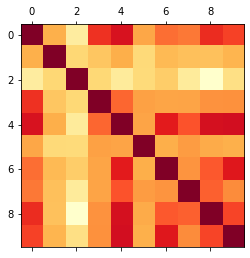

In [14]:
plt.matshow(datos.select_dtypes(include=['float64','int64','int']).corr(method='pearson'), cmap=plt.cm.YlOrRd)

#### Cálculo del Factor de inflación de la varianza (VIF) para las variables predictoras

- Si VIF = 1 -> No hay correlacion entre las vars
- Si VIF = 1-5 -> Existe cierta correlacion, pero las variables podrian seguir perteneciendo al modelo
- Si VIF > 5 -> Vars muy correlacionadas y han de ser eliminadas del modelo.

In [15]:
# calculo FIV para metros_habitables frente banyos
lm_n = smf.ols(formula="banyos~antiguedad", data=datos).fit()
rsquared_n = lm_n.rsquared
VIF = 1/(1-rsquared_n)
VIF

1.1507077583933585

In [16]:
# calculo FIV para metros_habitables frente dormitorios
lm_n = smf.ols(formula="precio_terreno~antiguedad", data=datos).fit()
rsquared_n = lm_n.rsquared
VIF = 1/(1-rsquared_n)
VIF

1.0004762473397795

In [17]:
# MATRIZ de VIFs para todas las columnas numericas:
# =================================================
cols = list(datos.select_dtypes(include=['float64','int64','int']).columns.values)

filaVIF=[]
arrayVIF = ''


for i in cols:
    for j in cols:
        var = i + '~'+ j
        if (i==j):
            VIF=999 # VIF(A~A) = 'inf' y peta. Debo darle un valor numerico)
        else:    
            lm_n = smf.ols(formula=var, data=datos).fit()
            rsquared_n = lm_n.rsquared
            VIF = round(1/(1-rsquared_n),0)
        #print('VIF('+var+')',VIF)
        filaVIF.append(VIF)
    #print('filaVIF: \n', filaVIF)
    npFilaVIF = np.array([filaVIF])
    filaVIF = []
    
    if (arrayVIF == ''):
        arrayVIF = npFilaVIF
    else:
        arrayVIF = np.append(arrayVIF, npFilaVIF , axis=0)
    #print('npFilaVIF_app:\n', npFilaVIF_old)
    
arrayVIF

<ipython-input-17-018b461a0279>:24: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if (arrayVIF == ''):


array([[999.,   1.,   1.,   2.,   2.,   1.,   1.,   1.,   2.,   1.],
       [  1., 999.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.],
       [  1.,   1., 999.,   1.,   1.,   1.,   1.,   1.,   1.,   1.],
       [  2.,   1.,   1., 999.,   1.,   1.,   1.,   1.,   1.,   1.],
       [  2.,   1.,   1.,   1., 999.,   1.,   2.,   1.,   2.,   2.],
       [  1.,   1.,   1.,   1.,   1., 999.,   1.,   1.,   1.,   1.],
       [  1.,   1.,   1.,   1.,   2.,   1., 999.,   1.,   1.,   2.],
       [  1.,   1.,   1.,   1.,   1.,   1.,   1., 999.,   1.,   1.],
       [  2.,   1.,   1.,   1.,   2.,   1.,   1.,   1., 999.,   1.],
       [  1.,   1.,   1.,   1.,   2.,   1.,   2.,   1.,   1., 999.]])

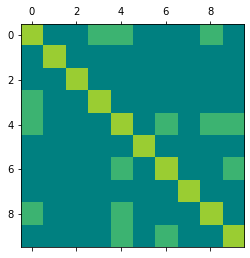

In [18]:
from matplotlib import colors
import matplotlib as mpl

cmap = colors.ListedColormap(['darkgreen','teal', 'mediumseagreen','yellowgreen'])

#cmap = mpl.cm.viridis

bounds = [0, 1, 2, 3, 5]
norm = colors.BoundaryNorm(bounds, cmap.N)

dummy = plt.matshow(arrayVIF, cmap=cmap, norm=norm)

#### Comprobacion de la linealidad entre la variable de salida y las variables predictoras

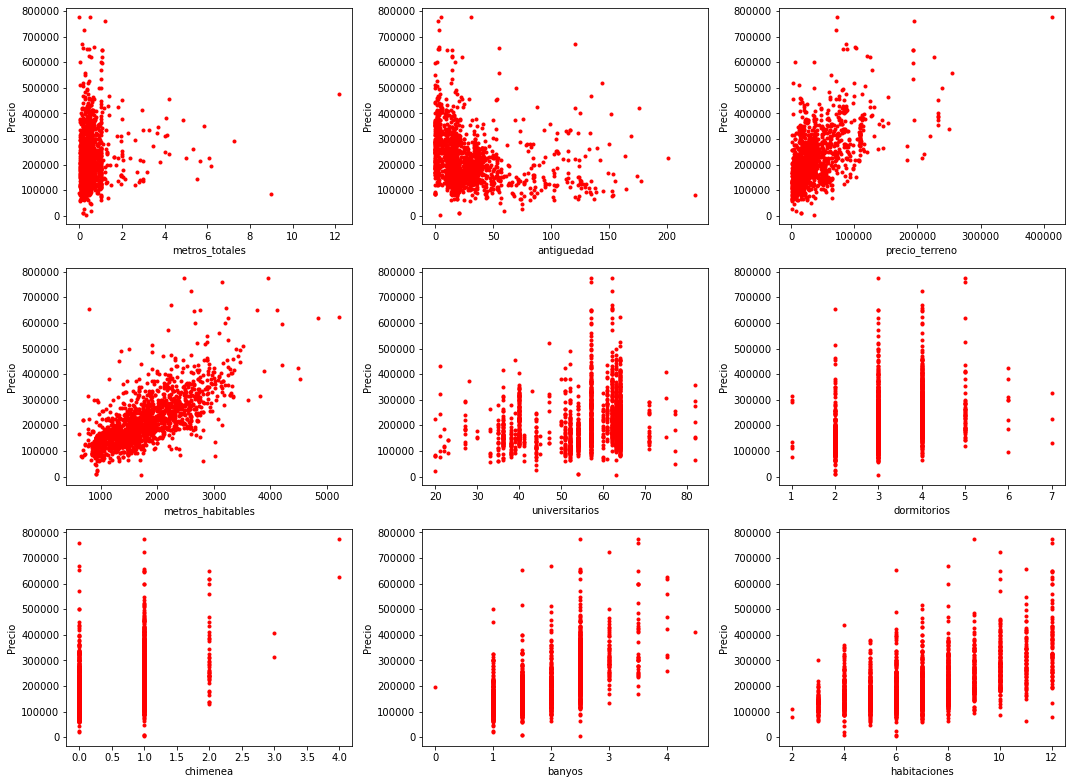

In [19]:
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15,11))

#ax is a two-dimensional array: one dimension for the rows, one for the columns.
#if you want to iterate through the subplots in the way you do it now, by flattening ax first: ax = ax.flatten()
#and now ax is a one dimensional array. 
axes = axes.flat

columnas_numeric = datos.select_dtypes(include=['float64', 'int64', 'int']).columns
columnas_numeric = columnas_numeric.drop('precio')

for i, col  in enumerate(columnas_numeric):
    axes[i].plot(datos[col], datos.precio, 'r.')
    axes[i].set(xlabel=col, ylabel='Precio')

fig.tight_layout()


#### Seleccion de variables predictoras con sckit-learn

In [20]:
from sklearn.feature_selection import RFE
from sklearn.svm import SVR

In [29]:
# Columnas que seran var predictivas numericas
feature_cols = datos.select_dtypes(include=['float64','int64','int']).columns.values.tolist()
feature_cols.pop(0) # quitamos el precio que es var de salida, no predictora
feature_cols

['metros_totales',
 'antiguedad',
 'precio_terreno',
 'metros_habitables',
 'universitarios',
 'dormitorios',
 'chimenea',
 'banyos',
 'habitaciones']

In [31]:
X = datos_testing[feature_cols]
Y = datos_testing['precio']

In [60]:
#start_time = time.time()
estimator = SVR(kernel='linear')
selector = RFE(estimator, 4, step=2) # quedarse con 4 var predictivas, quitando 1 var por paso de calculo
selector = selector.fit(X,Y)

# variables aceptadas para el modelo:
selector.support_
#print("--- %s seconds ---" % (time.time() - start_time))

C:\Users\mhern\anaconda3\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass n_features_to_select=4 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


array([False,  True, False,  True,  True,  True, False, False, False])

Obtenemos el nombre de las variables aceptadas mediante **<code>filtrado con array booleano</code>**:

In [61]:
list_a = datos.select_dtypes(include=['float64','int64','int']).columns.values
list_a = list_a[1:] # quitamos precio
filter = selector.support_
list_a[filter]

array(['antiguedad', 'metros_habitables', 'universitarios', 'dormitorios'],
      dtype=object)

Repetimos para los datos de training, y vemos que nos salen las mismas variables.

In [64]:
feature_cols = datos.select_dtypes(include=['float64','int64','int']).columns.values
feature_cols = feature_cols[1:] # quitamos precio

X = datos_training[feature_cols]
Y = datos_training['precio']

estimator = SVR(kernel='linear')
selector = RFE(estimator, 4, step=2) # quedarse con 4 var predictivas, quitando 1 var por paso de calculo
selector = selector.fit(X,Y)

# variables aceptadas para el modelo:
selector.support_

list_a = datos.select_dtypes(include=['float64','int64','int']).columns.values
list_a = list_a[1:] # quitamos precio
filter = selector.support_
list_a[filter]

C:\Users\mhern\anaconda3\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass n_features_to_select=4 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


array(['antiguedad', 'metros_habitables', 'universitarios',
       'habitaciones'], dtype=object)

### Variables categoricas

In [75]:
datos.select_dtypes(include=['object']).describe()

,calefaccion,consumo_calefacion,desague,vistas_lago,nueva_construccion,aire_acondicionado
count,1728,1728,1728,1728,1728,1728
unique,3,3,3,2,2,2
top,hot air,gas,public/commercial,No,No,No
freq,1121,1197,1213,1713,1647,1093


In [76]:
# valores unicos de cada var categorica:
for i in datos.select_dtypes(include=['object']):
    print(i, datos[i].unique())

calefaccion ['electric' 'hot water/steam' 'hot air']
consumo_calefacion ['electric' 'gas' 'oil']
desague ['septic' 'public/commercial' 'none']
vistas_lago ['No' 'Yes']
nueva_construccion ['No' 'Yes']
aire_acondicionado ['No' 'Yes']


Creamos las variables dummy para cada variable categorica:

In [77]:
dummy_calefaccion  = pd.get_dummies(datos['calefaccion'], prefix = 'calefaccion')
dummy_calefaccion.head()

,calefaccion_electric,calefaccion_hot air,calefaccion_hot water/steam
0,1,0,0
1,0,0,1
2,0,0,1
3,0,1,0
4,0,1,0


In [78]:
dummy_aire_acondicionado   = pd.get_dummies(datos['aire_acondicionado'], prefix = 'aire_acondicionado')
dummy_aire_acondicionado.head()

,aire_acondicionado_No,aire_acondicionado_Yes
0,1,0
1,1,0
2,1,0
3,1,0
4,0,1


Añadimos estas var dummies al dataset:

In [79]:
datos_new = datos.join(dummy_calefaccion)
column_names = datos_new.columns.values.tolist()
datos_new.head()

,precio,metros_totales,antiguedad,precio_terreno,metros_habitables,universitarios,dormitorios,chimenea,banyos,habitaciones,calefaccion,consumo_calefacion,desague,vistas_lago,nueva_construccion,aire_acondicionado,calefaccion_electric,calefaccion_hot air,calefaccion_hot water/steam
0,132500,0.09,42,50000,906,35,2,1,1.0,5,electric,electric,septic,No,No,No,1,0,0
1,181115,0.92,0,22300,1953,51,3,0,2.5,6,hot water/steam,gas,septic,No,No,No,0,0,1
2,109000,0.19,133,7300,1944,51,4,1,1.0,8,hot water/steam,gas,public/commercial,No,No,No,0,0,1
3,155000,0.41,13,18700,1944,51,3,1,1.5,5,hot air,gas,septic,No,No,No,0,1,0
4,86060,0.11,0,15000,840,51,2,0,1.0,3,hot air,gas,public/commercial,No,Yes,Yes,0,1,0


Comprobemos la relacion lineal entre la variable de salida (precio) con las categoricas (a traves de lso dummies):

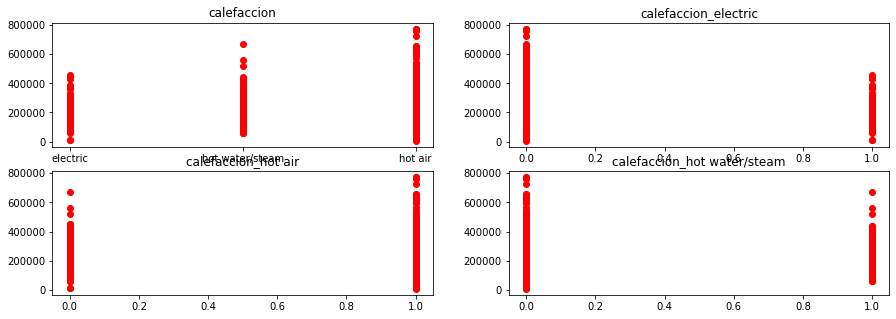

In [80]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15,5))
axes = axes.ravel() # importante aplanar porque subplots devuelve las figuras como una lista de listas!

columnas_object = ['calefaccion', 'calefaccion_electric','calefaccion_hot air','calefaccion_hot water/steam']

for i, cols in enumerate(columnas_object):
    axes[i].plot(datos_new[cols],datos_new.precio,'ro')
    axes[i].set_title(cols)

### Modelo

1) Calculo mejores variables predictoras mediante scikit-learn (incluye variables binarias): 

In [87]:
datos_dummy = datos_new.select_dtypes(include=['float64','int64','int','uint8'])

a = np.random.randn(len(datos_dummy))
check = (a<0.8)
datos_dummy_training = datos_dummy[check]
datos_dummy_testing = datos_dummy[~check]

len(datos_dummy_training), len(datos_dummy_testing)

(1402, 326)

In [91]:
feature_cols = datos_dummy_training.columns.values
feature_cols = feature_cols[1:] # quitamos precio

X = datos_dummy_training[feature_cols]
Y = datos_dummy_training['precio']

estimator = SVR(kernel='linear')
selector = RFE(estimator, 4, step=2) # quedarse con 4 var predictivas, quitando 1 var por paso de calculo
selector = selector.fit(X,Y)

# variables aceptadas para el modelo:
selector.support_

list_a = datos_dummy_training.select_dtypes(include=['float64','int64','int','uint8']).columns.values
list_a = list_a[1:] # quitamos precio
filter = selector.support_
list_a[filter]

C:\Users\mhern\anaconda3\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass n_features_to_select=4 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


array(['antiguedad', 'metros_habitables', 'universitarios',
       'habitaciones'], dtype=object)

In [96]:
# Añadir al modelo existente las vars predictoras una a una 
lm = smf.ols(formula="precio~metros_habitables+universitarios+habitaciones", data = datos_training).fit()
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 precio   R-squared:                       0.514
Model:                            OLS   Adj. R-squared:                  0.513
Method:                 Least Squares   F-statistic:                     474.2
Date:                Mon, 17 Jan 2022   Prob (F-statistic):          3.49e-210
Time:                        23:15:19   Log-Likelihood:                -16978.
No. Observations:                1350   AIC:                         3.396e+04
Df Residuals:                    1346   BIC:                         3.398e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept         -1.858e+04   1.13e+04     -1.646      0.100   -4.07e+04    3569.025
metros_habitables   110.3882      4.563     24.193      0.000     101.437     119.339
universitarios      552.9136    189.907      2.911      0.004     180.367     925.460
habitaciones        831.7018   1220.179      0.682      0.496   -1561.957    3225.360
==============================================================================
Omnibus:                      492.781   Durbin-Watson:                   1.494
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2894.738
Skew:                           1.581   Prob(JB):                         0.00
Kurtosis:                       9.439   Cond. No.                     1.11e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.11e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

2) A ojo, añadir al modelo existente las vars predictoras una a una 

In [95]:
# Añadir al modelo existente las vars predictoras una a una 
lm = smf.ols(formula="precio~metros_habitables", data = datos_training).fit()
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 precio   R-squared:                       0.511
Model:                            OLS   Adj. R-squared:                  0.510
Method:                 Least Squares   F-statistic:                     1406.
Date:                Mon, 17 Jan 2022   Prob (F-statistic):          2.18e-211
Time:                        23:13:59   Log-Likelihood:                -16983.
No. Observations:                1350   AIC:                         3.397e+04
Df Residuals:                    1348   BIC:                         3.398e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept           1.06e+04   5719.119      1.854      0.064    -617.704    2.18e+04
metros_habitables   114.6246      3.057     37.499      0.000     108.628     120.621
==============================================================================
Omnibus:                      487.703   Durbin-Watson:                   1.495
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2873.687
Skew:                           1.561   Prob(JB):                         0.00
Kurtosis:                       9.430   Cond. No.                     5.59e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.59e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [14]:
# +precio_terreno
lm = smf.ols(formula="precio~metros_habitables+precio_terreno", data = datos_training).fit()
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 precio   R-squared:                       0.604
Model:                            OLS   Adj. R-squared:                  0.604
Method:                 Least Squares   F-statistic:                     1020.
Date:                Mon, 17 Jan 2022   Prob (F-statistic):          1.29e-269
Time:                        18:10:37   Log-Likelihood:                -16659.
No. Observations:                1338   AIC:                         3.332e+04
Df Residuals:                    1335   BIC:                         3.334e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept          2.246e+04   5116.045      4.390      0.000    1.24e+04    3.25e+04
metros_habitables    87.9639      3.026     29.069      0.000      82.028      93.900
precio_terreno        0.9914      0.053     18.862      0.000       0.888       1.095
==============================================================================
Omnibus:                      484.478   Durbin-Watson:                   1.735
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3542.125
Skew:                           1.490   Prob(JB):                         0.00
Kurtosis:                      10.393   Cond. No.                     1.51e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.51e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [15]:
# +antiguedad
lm = smf.ols(formula="precio~metros_habitables+precio_terreno+antiguedad", data = datos_training).fit()
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 precio   R-squared:                       0.611
Model:                            OLS   Adj. R-squared:                  0.610
Method:                 Least Squares   F-statistic:                     699.3
Date:                Mon, 17 Jan 2022   Prob (F-statistic):          4.24e-273
Time:                        18:10:43   Log-Likelihood:                -16648.
No. Observations:                1338   AIC:                         3.330e+04
Df Residuals:                    1334   BIC:                         3.332e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept          3.443e+04   5644.184      6.100      0.000    2.34e+04    4.55e+04
metros_habitables    85.3487      3.049     27.991      0.000      79.367      91.330
precio_terreno        1.0061      0.052     19.267      0.000       0.904       1.108
antiguedad         -278.7921     57.591     -4.841      0.000    -391.771    -165.813
==============================================================================
Omnibus:                      516.672   Durbin-Watson:                   1.717
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3968.316
Skew:                           1.592   Prob(JB):                         0.00
Kurtosis:                      10.813   Cond. No.                     1.68e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.68e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [16]:
# +metros_totales
lm = smf.ols(formula="precio~precio_terreno+antiguedad+metros_totales", data = datos_training).fit()
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 precio   R-squared:                       0.614
Model:                            OLS   Adj. R-squared:                  0.612
Method:                 Least Squares   F-statistic:                     529.3
Date:                Mon, 17 Jan 2022   Prob (F-statistic):          2.19e-273
Time:                        18:10:48   Log-Likelihood:                -16644.
No. Observations:                1338   AIC:                         3.330e+04
Df Residuals:                    1333   BIC:                         3.332e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept          3.354e+04   5637.995      5.949      0.000    2.25e+04    4.46e+04
metros_habitables    83.9049      3.083     27.213      0.000      77.856      89.954
precio_terreno        1.0066      0.052     19.329      0.000       0.904       1.109
antiguedad         -281.8937     57.449     -4.907      0.000    -394.595    -169.193
metros_totales     6929.1452   2439.084      2.841      0.005    2144.285    1.17e+04
==============================================================================
Omnibus:                      526.319   Durbin-Watson:                   1.714
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             4244.840
Skew:                           1.612   Prob(JB):                         0.00
Kurtosis:                      11.109   Cond. No.                     1.68e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.68e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [17]:
# +habitaciones 
lm = smf.ols(formula="precio~metros_habitables+precio_terreno+antiguedad+metros_totales+habitaciones", 
             data = datos_training).fit()
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 precio   R-squared:                       0.615
Model:                            OLS   Adj. R-squared:                  0.614
Method:                 Least Squares   F-statistic:                     426.4
Date:                Mon, 17 Jan 2022   Prob (F-statistic):          2.38e-273
Time:                        18:10:53   Log-Likelihood:                -16640.
No. Observations:                1338   AIC:                         3.329e+04
Df Residuals:                    1332   BIC:                         3.332e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept           2.81e+04   6033.364      4.657      0.000    1.63e+04    3.99e+04
metros_habitables    76.4583      4.282     17.854      0.000      68.057      84.859
precio_terreno        1.0081      0.052     19.394      0.000       0.906       1.110
antiguedad         -290.2707     57.434     -5.054      0.000    -402.942    -177.599
metros_totales     6707.2918   2435.910      2.754      0.006    1928.655    1.15e+04
habitaciones       2670.5646   1068.076      2.500      0.013     575.269    4765.860
==============================================================================
Omnibus:                      526.797   Durbin-Watson:                   1.714
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             4221.728
Skew:                           1.616   Prob(JB):                         0.00
Kurtosis:                      11.080   Cond. No.                     1.81e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.81e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [97]:
# +universitarios 
lm = smf.ols(formula="precio~metros_habitables+precio_terreno+antiguedad+metros_totales+habitaciones+universitarios", 
             data = datos_training).fit()
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 precio   R-squared:                       0.614
Model:                            OLS   Adj. R-squared:                  0.612
Method:                 Least Squares   F-statistic:                     355.3
Date:                Mon, 17 Jan 2022   Prob (F-statistic):          5.02e-273
Time:                        23:19:45   Log-Likelihood:                -16823.
No. Observations:                1350   AIC:                         3.366e+04
Df Residuals:                    1343   BIC:                         3.370e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept          2.322e+04   1.05e+04      2.203      0.028    2543.528    4.39e+04
metros_habitables    83.0021      4.342     19.117      0.000      74.485      91.520
precio_terreno        0.9604      0.054     17.830      0.000       0.855       1.066
antiguedad         -304.5945     58.314     -5.223      0.000    -418.991    -190.198
metros_totales     7858.2113   2388.238      3.290      0.001    3173.128    1.25e+04
habitaciones       1487.4612   1091.112      1.363      0.173    -653.008    3627.931
universitarios       65.9291    171.977      0.383      0.702    -271.443     403.302
==============================================================================
Omnibus:                      450.123   Durbin-Watson:                   1.664
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2554.134
Skew:                           1.435   Prob(JB):                         0.00
Kurtosis:                       9.096   Cond. No.                     3.09e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.09e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

**NOTA:** Nos quedamos con las variables metros_habitables, precio_terreno, antiguedad, r2 = 0.611

#### Cálculo del error en el modelo con datos training

In [28]:
precio_pred = lm.predict(datos_training)

In [31]:
SSD = sum((datos_training['precio']-precio_pred)**2)
SSD

5024923870590.765

In [32]:
RSE = np.sqrt(SSD/(len(datos_training)-2-1))
RSE

61351.3481355179

In [33]:
precio_mean = np.mean(datos_training['precio'])
error = RSE/precio_mean
error*100

28.97440700421129

#### Validación del modelo con datos de testing

In [24]:
precio_pred = lm.predict(datos_testing)
precio_pred.head()

0     150350.087128
2     170613.612279
7     184556.574244
11    195193.336881
12     95721.144153
dtype: float64

In [25]:
# veamos como difiere esta prediccion del original
SSD = sum((datos_testing['precio']-precio_pred)**2)
SSD

1510108728953.1833

In [22]:
RSE = np.sqrt(SSD/(len(datos_testing)-2-1))
RSE

62466.70904487537

In [27]:
precio_mean = np.mean(datos_testing['precio'])
error = RSE/precio_mean
error*100

29.363851461850903